
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [2]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [3]:
data_path = "/kaggle/input/captcha-version-2-images/samples"

In [4]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1071
[5 7]


In [5]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

576 samples


In [6]:
image_fns.remove('samples')
print(len(image_fns))

1070


In [7]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)
print(len(image_fns_train), len(image_fns_test))

802 268


## 2. Define character maps

In [8]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [9]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


## 3. Define data loader

In [10]:
batch_size = 16

In [11]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [12]:
trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

51 17


In [13]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('nbp3e', 'c86md', '6pfy4', 'e3cfe', '7gce6', 'f858x', 'mcc2x', 'bp2d4', '74853', 'bw44w', 'w6ny4', 'nn6w6', '7cgym', 'n3bm6', 'm3b5p', 'mxyxw')


## 4. Define model

In [14]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
resnet = resnet18(pretrained=True)
#print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [17]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [19]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [20]:
#crnn

In [21]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('nbp3e', 'c86md', '6pfy4', 'e3cfe', '7gce6', 'f858x', 'mcc2x', 'bp2d4', '74853', 'bw44w', 'w6ny4', 'nn6w6', '7cgym', 'n3bm6', 'm3b5p', 'mxyxw')
torch.Size([10, 16, 20])


## 5. Define loss

In [22]:
criterion = nn.CTCLoss(blank=0)

In [23]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [24]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [25]:
compute_loss(text_batch, text_batch_logits)

tensor(4.5599, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [26]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [27]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [28]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [29]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Epoch:1    Loss:2.9900871351653455    NumUpdates:51


Epoch:2    Loss:2.419498644623102    NumUpdates:51


Epoch:3    Loss:1.9921862167470596    NumUpdates:51


Epoch:4    Loss:1.6599087832020778    NumUpdates:51


Epoch:5    Loss:1.4582493959688674    NumUpdates:51


Epoch:6    Loss:1.3014318709279977    NumUpdates:51


Epoch:7    Loss:1.2249731339660346    NumUpdates:51


Epoch:8    Loss:1.1271169396007763    NumUpdates:51


Epoch:9    Loss:1.0210105472919988    NumUpdates:51


Epoch:10    Loss:0.9753329952557882    NumUpdates:51


Epoch:11    Loss:0.9316047196294747    NumUpdates:51


Epoch:12    Loss:0.8916015344507554    NumUpdates:51


Epoch:13    Loss:0.8738840070425296    NumUpdates:51


Epoch:14    Loss:0.8947969651689717    NumUpdates:51


Epoch:15    Loss:0.8399395264831244    NumUpdates:51


Epoch:16    Loss:0.8126519462641548    NumUpdates:51


Epoch:17    Loss:0.8683857064621121    NumUpdates:51


Epoch:18    Loss:0.8311487120740554    NumUpdates:51


Epoch:19    Loss:0.8097569393176659    NumUpdates:51


Epoch:20    Loss:0.7513260782933703    NumUpdates:51


Epoch:21    Loss:0.736772402828815    NumUpdates:51


Epoch:22    Loss:0.7255906228925667    NumUpdates:51


Epoch:23    Loss:0.7293911389276093    NumUpdates:51


Epoch:24    Loss:0.7188699058457917    NumUpdates:51


Epoch:25    Loss:0.844322102911332    NumUpdates:51


Epoch:26    Loss:0.8478556462362701    NumUpdates:51


Epoch:27    Loss:0.7318797380316491    NumUpdates:51


Epoch:28    Loss:0.6731003663119148    NumUpdates:51


Epoch:29    Loss:0.6562695842163235    NumUpdates:51


Epoch:30    Loss:0.6465148189488579    NumUpdates:51


Epoch:31    Loss:0.6488102206996843    NumUpdates:51


Epoch:32    Loss:0.6641178142790701    NumUpdates:51


Epoch:33    Loss:0.8547234593653211    NumUpdates:51


Epoch:34    Loss:0.7804392471032984    NumUpdates:51


Epoch:35    Loss:0.6723369675524095    NumUpdates:51


Epoch:36    Loss:0.6460016451629937    NumUpdates:51


Epoch:37    Loss:0.6240485719605988    NumUpdates:51


Epoch:38    Loss:0.6367446721768847    NumUpdates:51


Epoch:39    Loss:0.6285087992163265    NumUpdates:51


Epoch:40    Loss:0.6388927207273596    NumUpdates:51


Epoch:41    Loss:0.7857545999919667    NumUpdates:51


Epoch:42    Loss:0.7721711233550427    NumUpdates:51


Epoch:43    Loss:0.6579085272901198    NumUpdates:51
Epoch    43: reducing learning rate of group 0 to 1.0000e-04.


Epoch:44    Loss:0.5907929399434257    NumUpdates:51


Epoch:45    Loss:0.567648145498014    NumUpdates:51


Epoch:46    Loss:0.5579055430842381    NumUpdates:51


Epoch:47    Loss:0.5511149986117494    NumUpdates:51


Epoch:48    Loss:0.5489027768957848    NumUpdates:51


Epoch:49    Loss:0.5459187615151498    NumUpdates:51


Epoch:50    Loss:0.545354514729743    NumUpdates:51



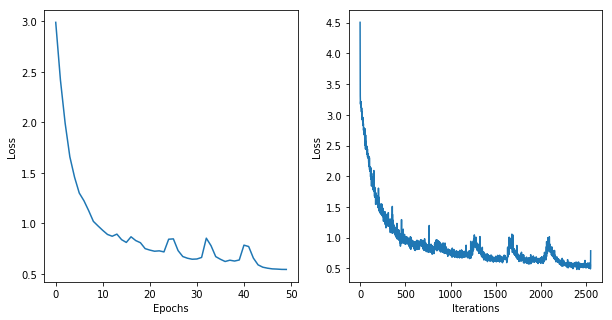

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [31]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [32]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [33]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [34]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,pcm7f,ppccmm77ff
1,377xx,337777x-xx
2,6g45w,66gg4455ww
3,mc35n,mmcc3355nn
4,5mfff,55mmfff-ff


In [35]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,2fxgd,22ffxxggdd
1,y5n6d,yy55nn66dd
2,8gmnx,88ggmmnnxx
3,wm47f,wwmmmm77ff
4,dn26n,ddnn2266nn


In [36]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [37]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,pcm7f,ppccmm77ff,pcm7f
1,377xx,337777x-xx,37xx
2,6g45w,66gg4455ww,6g45w
3,mc35n,mmcc3355nn,mc35n
4,5mfff,55mmfff-ff,5mff


In [38]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,2fxgd,22ffxxggdd,2fxgd
1,y5n6d,yy55nn66dd,y5n6d
2,8gmnx,88ggmmnnxx,8gmnx
3,wm47f,wwmmmm77ff,wm7f
4,dn26n,ddnn2266nn,dn26n


## 8. Evaluate the model

In [39]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
3,wm47f,wwmmmm77ff,wm7f
42,pmg55,ppmmgg5555,pmg5
64,mddgb,mmddddggbb,mdgb
74,mmy5n,mmmmyy55nn,my5n
77,6n6gg,66nn66gggg,6n6g
78,664nf,666644nnff,64nf
80,x775w,xx777755ww,x75w
81,55y2m,5555yy22mm,5y2m
88,f2fge,ff22ggggee,f2ge
92,d666m,dd6---66mm,d66m


In [40]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

4    29
5     2
3     2
Name: prediction_corrected, dtype: int64


In [41]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
196,mxnw4,mmxxmmww44,mxmw4
254,wgnwp,wwggmmwwpp,wgmwp


/kaggle/input/captcha-version-2-images/samples/mxnw4.png


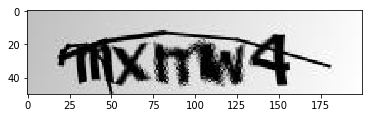

In [42]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [43]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.92643391521197
0.8768656716417911
